# SHAP Notebook - Explainable AI 

This notebook primarily uses SHAP to explain multiple learners on the proteomics and genomics datasets from GDSC and CCLE

## Import Data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)


## Palbociclib GDSC with Goncalves et al proteomics (preprocessed & normalised)

In [3]:
# create feature and target 

import DataFunctions as utils

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc('Palbociclib',
                                                                         joined_sin_peptile_exclusion_matrix, gdsc2)

feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)



### Model ElasticNet - All Features

score using selected features: 2.3212, score using all features: 2.1718


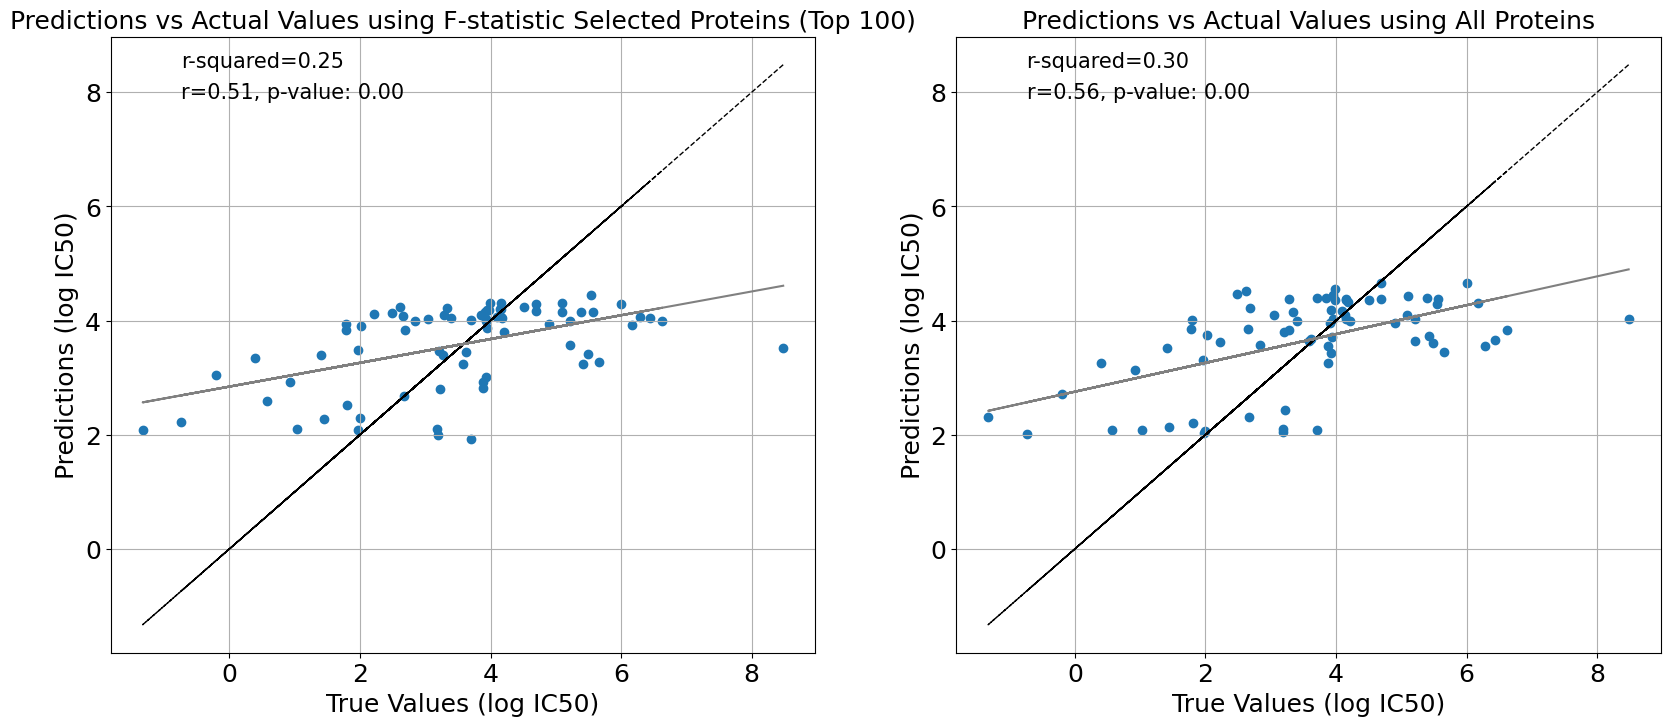

In [8]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet, ElasticNetCV

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression


import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

model = ElasticNet()
model.fit(X_train[selected_features], y_train)

model_all = ElasticNet()
model_all.fit(X_train, y_train)

# get the predictions

y_pred = model.predict(X_test[selected_features])
predictions_all_features = model_all.predict(X_test)

# get the score


score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(
    f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values


# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0],
                                      title='Predictions vs Actual Values using F-statistic Selected Proteins (Top 100)',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1],
                                      title='Predictions vs Actual Values using All Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
# show the plot
plt.show()


#### SHAP Analysis

In [12]:
# Use SHAP to extract feature importance

import shap

# create the explainer

explainer = shap.LinearExplainer(model_all, X_train)

# get the shap values

shap_values = explainer(X_test)

In [22]:
print(shap_values.shape)
print(X_test.shape)

(74, 6692)
(74, 6692)


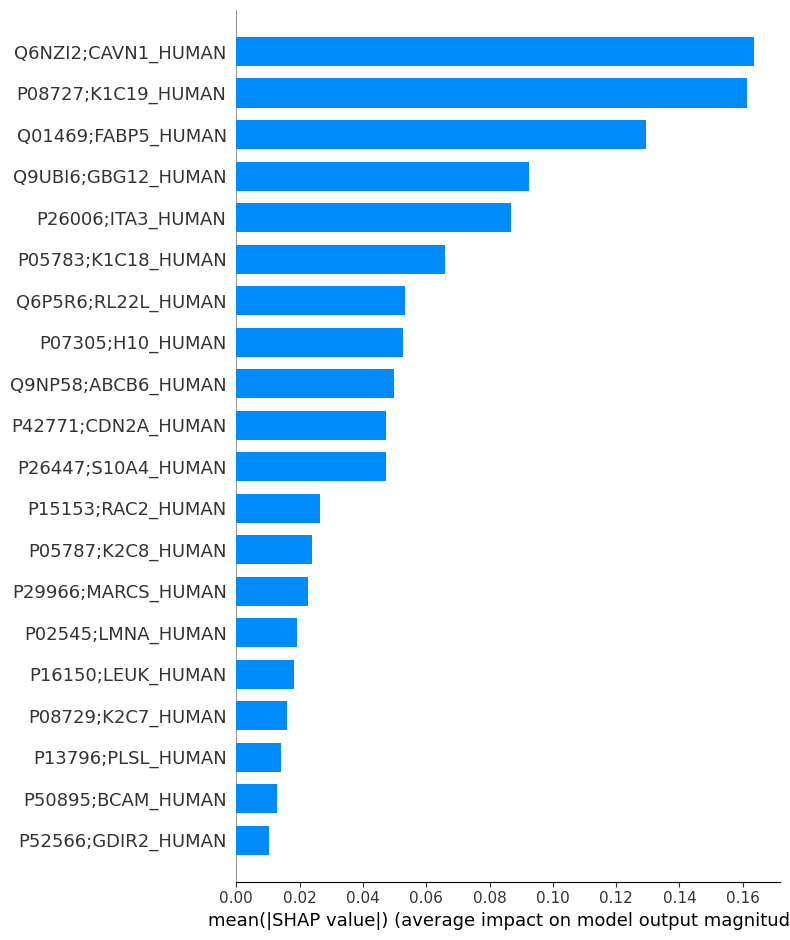

In [13]:
# plot the shap values

shap.summary_plot(shap_values, X_test, plot_type="bar")


#### Monte Carlo CV with SHAP

In [23]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet

repeats = 100
test_size = 0.1
exp_ids = ['All Proteins']
feature_selection_size = [feature_data.shape[1]]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'shap_features', 'x_test', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = int(np.random.random()*100000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        model = ElasticNet()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        explainer = shap.LinearExplainer(model_all, X_train)
        shap_values = explainer(X_test)
        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), shap_values, X_test, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 1.8290, pearson corr: 0.6074, pearson p_val: 0.0000, r_squared: 0.3496
iteration: 1, score: 1.4865, pearson corr: 0.5968, pearson p_val: 0.0000, r_squared: 0.3406
iteration: 2, score: 1.7786, pearson corr: 0.5929, pearson p_val: 0.0000, r_squared: 0.3181
iteration: 3, score: 1.7923, pearson corr: 0.6416, pearson p_val: 0.0000, r_squared: 0.3788
iteration: 4, score: 2.3915, pearson corr: 0.6881, pearson p_val: 0.0000, r_squared: 0.3765
iteration: 5, score: 1.6307, pearson corr: 0.4982, pearson p_val: 0.0000, r_squared: 0.2477
iteration: 6, score: 1.8614, pearson corr: 0.5714, pearson p_val: 0.0000, r_squared: 0.3075
iteration: 7, score: 1.8275, pearson corr: 0.5060, pearson p_val: 0.0000, r_squared: 0.2550
iteration: 8, score: 1.8178, pearson corr: 0.6152, pearson p_val: 0.0000, r_squared: 0.3509
iteration: 9, score: 1.5611, pearson corr: 0.5923, pearson p_val: 0.0000, r_squared: 0.3399
iteration: 10, score: 1.1744, pearson corr: 0.6340, pearson p_val: 0.0000, r_squ

#### Mean Abs Value Bar Plot Visualisation

55


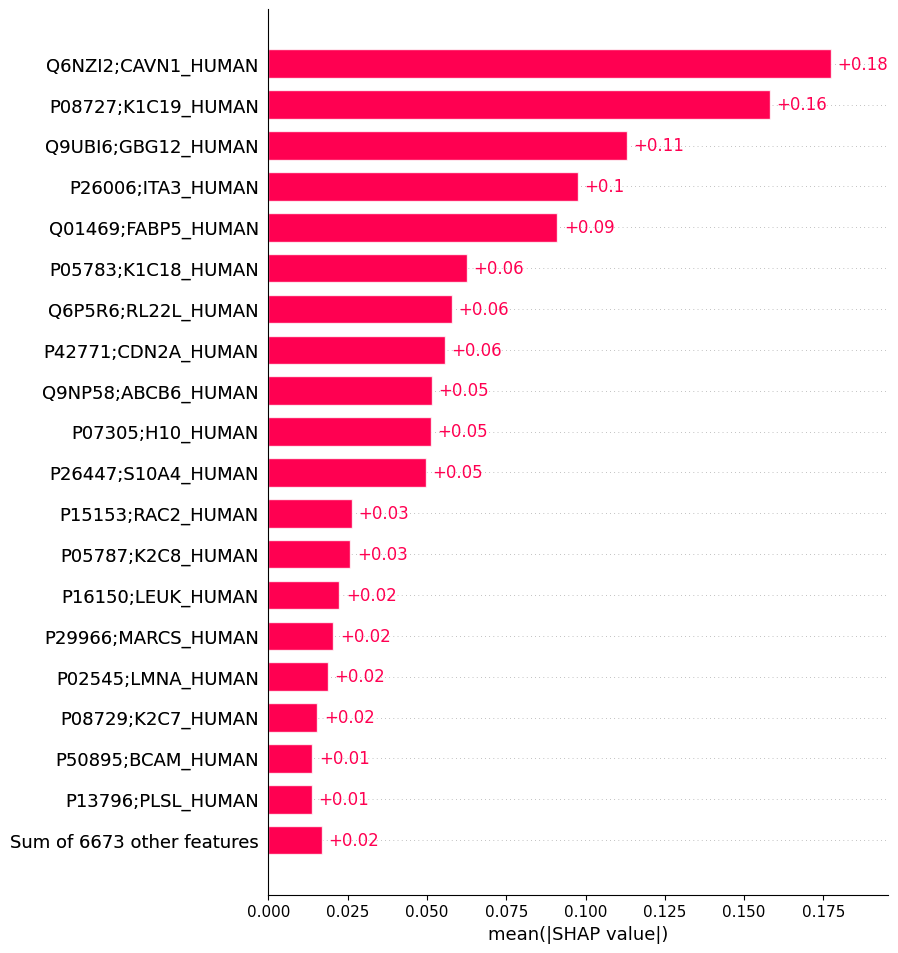

In [41]:
shap_plot_vals = [(x, y) for x, y in zip(collection_df['shap_features'], collection_df['x_test'])]

# plot a random row of the shap values 

random_row = int(np.random.random()*repeats)
print(random_row)
shap_values = shap_plot_vals[random_row][0]
X_test = shap_plot_vals[random_row][1] 

shap.plots.bar(shap_values, max_display=20, show=False)

# shows mean abs value

#### Extract feature importance from a single run

In [50]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(20)




,col_name,feature_importance_vals
3137,Q6NZI2;CAVN1_HUMAN,0.177357
361,P08727;K1C19_HUMAN,0.158058
2939,Q9UBI6;GBG12_HUMAN,0.113114
240,P26006;ITA3_HUMAN,0.097477
4048,Q01469;FABP5_HUMAN,0.091112
1100,P05783;K1C18_HUMAN,0.062602
5349,Q6P5R6;RL22L_HUMAN,0.057874
2355,P42771;CDN2A_HUMAN,0.055530
1983,Q9NP58;ABCB6_HUMAN,0.051597
5765,P07305;H10_HUMAN,0.051182


#### Max Value Bar Plot Visualisation

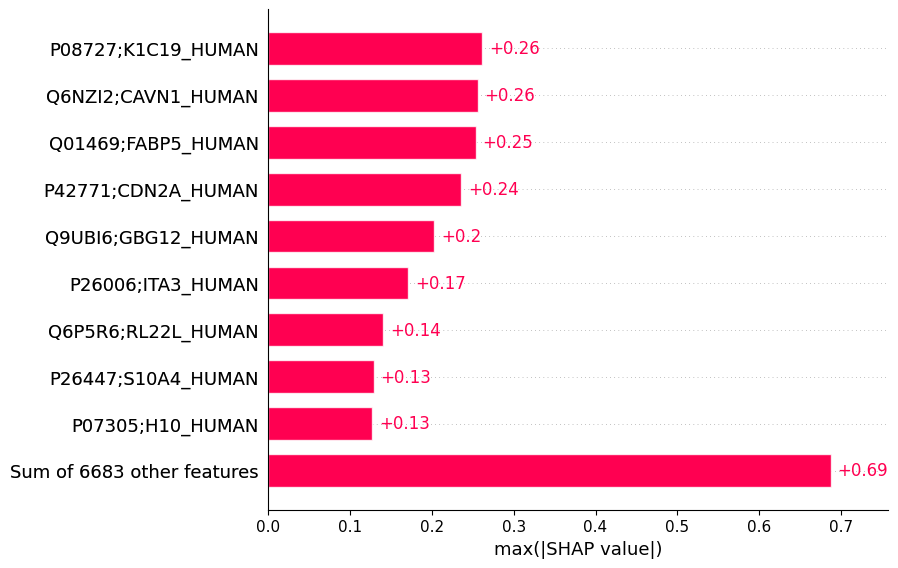

In [42]:
shap.plots.bar(shap_values.abs.max(0))


#### Beeswarm Visualisation of All Iterations

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


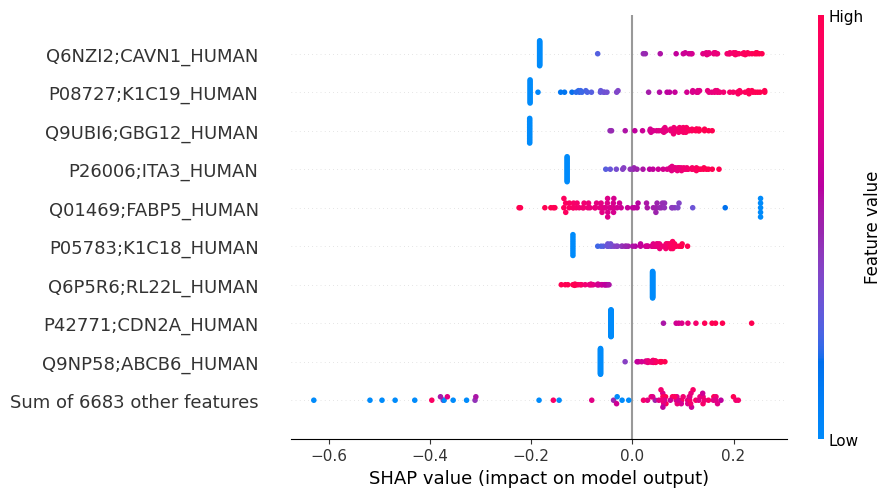

In [43]:
shap.plots.beeswarm(shap_values)
